In [1]:
import sys
from copy import deepcopy
from geoopt.optim import RiemannianAdam
sys.path.append("./")
sys.path.append("../")
sys.path.append("../../")
import numpy as np
import json
import pickle
import os
import torch
from rnn_coach.src.RNN_torch import *
from rnn_coach.src.DynamicSystemAnalyzer import *
from rnn_coach.src.RNN_numpy import *
from rnn_coach.src.Task import *
from rnn_coach.src.DataSaver import *
from src.utils import jsonify
from latent_circuit_inference.src.LatentCircuit import *
from latent_circuit_inference.src.LatentCircuitFitter import *
from latent_circuit_inference.src.LCAnalyzer import *
from latent_circuit_inference.src.utils import *
from latent_circuit_inference.src.circuit_vizualization import *
from matplotlib import pyplot as plt

In [2]:
def mse_scoring(x, y):
    return np.mean((x - y) ** 2)

def R2(x, y):
    return 1.0 - mse_scoring(x, y)/np.var(y)

RNN_folder = "0.0073745_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.1;lr=0.002;maxiter=3000"
tag = '8nodes'

disp = False
RNN_folder_full_path = os.path.join("../", "../", "rnn_coach", "data", "trained_RNNs", "CDDM", RNN_folder)
mse_score_RNN = os.listdir(RNN_folder_full_path)[2].split("_")[0]
rnn_config = json.load(open(os.path.join(RNN_folder_full_path, f"{mse_score_RNN}_config.json"), "rb+"))
rnn_data = json.load(open(os.path.join(RNN_folder_full_path, f"{mse_score_RNN}_params_CDDM.json"), "rb+"))
LCI_config_file = json.load(open(os.path.join("../", "data", "configs", f"LCI_config_{tag}.json"), mode="r", encoding='utf-8'))
task_data = rnn_config["task_params"]
tmp = task_data["coherences"][-1] * np.logspace(-(5 - 1), 0, 5, base=2)
coherences = np.concatenate([-np.array(tmp[::-1]), np.array([0]), np.array(tmp)]).tolist()
task_data["coherences"] = deepcopy(coherences)

In [15]:
# defining RNN:
activation_name = rnn_config["activation"]
RNN_N = rnn_config["N"]

if activation_name == 'relu':
    activation_RNN = lambda x: torch.maximum(x, torch.tensor(0))
elif activation_name == 'tanh':
    activation_RNN = torch.tanh
elif activation_name == 'sigmoid':
    activation_RNN = lambda x: 1/(1 + torch.exp(-x))
elif activation_name == 'softplus':
    activation_RNN = lambda x: torch.log(1 + torch.exp(5 * x))
dt = rnn_config["dt"]
tau = rnn_config["tau"]
connectivity_density_rec = rnn_config["connectivity_density_rec"]
spectral_rad = rnn_config["sr"]
sigma_inp = rnn_config["sigma_inp"]
sigma_rec = rnn_config["sigma_rec"]
seed = np.random.randint(1000000)
print(f"seed: {seed}")
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
rng = torch.Generator(device=torch.device(device))
if not seed is None:
    rng.manual_seed(seed)
input_size = np.array(rnn_data["W_inp"]).shape[1]
output_size = np.array(rnn_data["W_out"]).shape[0]

# Task:
n_steps = task_data["n_steps"]

# LC
n = LCI_config_file["n"]
LC_N = LCI_config_file["N"]
w_inp = np.random.rand(8, 6) ######! removing constraints!
w_out = np.array(LCI_config_file["W_out"])

# Fitter:
lambda_w = 0.5
max_iter = LCI_config_file["max_iter"]
tol = LCI_config_file["tol"]
lr = 0.01
actvation_name = LCI_config_file["activation"]
inp_connectivity_mask = np.ones((8, 6)) ######! removing constraints!
rec_connectivity_mask = np.array(LCI_config_file["rec_connectivity_mask"])
out_connectivity_mask = np.array(LCI_config_file["out_connectivity_mask"])
Qinitialization = LCI_config_file["Qinitialization"]

if activation_name == 'relu':
    activation_LC = lambda x: torch.maximum(x, torch.tensor(0))
elif activation_name == 'tanh':
    activation_LC = torch.tanh
elif activation_name == 'sigmoid':
    activation_LC = lambda x: 1/(1 + torch.exp(-x))
elif activation_name == 'softplus':
    activation_LC = lambda x: torch.log(1 + torch.exp(5 * x))

seed: 453913


In [16]:
lambda_w

0.5

In [17]:
# # creating instances:
rnn_torch = RNN_torch(N=RNN_N, dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                      activation=activation_RNN, random_generator=rng, device=device,
                      sigma_rec=sigma_rec, sigma_inp=sigma_inp)
RNN_params = {"W_inp": np.array(rnn_data["W_inp"]),
              "W_rec": np.array(rnn_data["W_rec"]),
              "W_out": np.array(rnn_data["W_out"]),
              "b_rec": np.array(rnn_data["bias_rec"]),
              "y_init": np.zeros(RNN_N)}
rnn_torch.set_params(RNN_params)
task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_data)

lc = LatentCircuit(n=n,
                   N=LC_N,
                   W_inp=torch.Tensor(w_inp).to(device),
                   W_out=torch.Tensor(w_out).to(device),
                   inp_connectivity_mask=torch.Tensor(inp_connectivity_mask).to(device),
                   rec_connectivity_mask=torch.Tensor(rec_connectivity_mask).to(device),
                   out_connectivity_mask=torch.Tensor(out_connectivity_mask).to(device),
                   activation=activation_LC,
                   sigma_rec=sigma_rec,
                   sigma_inp=sigma_inp,
                   device=device,
                   random_generator=rng)
criterion = torch.nn.MSELoss()

# optimizer = torch.optim.Adam(lc.parameters(), lr=lr)
optimizer = RiemannianAdam(lc.parameters(), lr=lr)

fitter = LatentCircuitFitter(LatentCircuit=lc, RNN=rnn_torch, Task=task,
                             max_iter=max_iter, tol=tol,
                             optimizer=optimizer, criterion=criterion,
                             lambda_w=lambda_w,
                             Qinitialization=Qinitialization)

Using cpu for RNN!
Using cpu for Latent Circuit!


In [18]:
lc_inferred, train_losses, val_losses, net_params = fitter.run_training()

setting projection of RNN traces on the lower subspace
iteration 0, train loss: 10.264995, validation loss: 1.999875
iteration 1, train loss: 8.7433, validation loss: 1.749309
iteration 2, train loss: 7.567688, validation loss: 1.551275
iteration 3, train loss: 6.669681, validation loss: 1.392498
iteration 4, train loss: 5.928522, validation loss: 1.26389
iteration 5, train loss: 5.348319, validation loss: 1.158949
iteration 6, train loss: 4.872703, validation loss: 1.073108
iteration 7, train loss: 4.490753, validation loss: 1.00236
iteration 8, train loss: 4.178538, validation loss: 0.943568
iteration 9, train loss: 3.915442, validation loss: 0.894416
iteration 10, train loss: 3.697817, validation loss: 0.853081
iteration 11, train loss: 3.519691, validation loss: 0.818008
iteration 12, train loss: 3.36599, validation loss: 0.787801
iteration 13, train loss: 3.238752, validation loss: 0.761442
iteration 14, train loss: 3.131858, validation loss: 0.737987
iteration 15, train loss: 3.0

iteration 103, train loss: 1.566273, validation loss: 0.359678
iteration 104, train loss: 1.564092, validation loss: 0.358749
iteration 105, train loss: 1.561264, validation loss: 0.357834
iteration 106, train loss: 1.558769, validation loss: 0.356931
iteration 107, train loss: 1.552839, validation loss: 0.356042
iteration 108, train loss: 1.55007, validation loss: 0.355163
iteration 109, train loss: 1.547951, validation loss: 0.354293
iteration 110, train loss: 1.542463, validation loss: 0.353436
iteration 111, train loss: 1.5388, validation loss: 0.35259
iteration 112, train loss: 1.53668, validation loss: 0.351757
iteration 113, train loss: 1.534793, validation loss: 0.350935
iteration 114, train loss: 1.533695, validation loss: 0.350125
iteration 115, train loss: 1.528203, validation loss: 0.349325
iteration 116, train loss: 1.526948, validation loss: 0.348536
iteration 117, train loss: 1.523439, validation loss: 0.347757
iteration 118, train loss: 1.517141, validation loss: 0.3469

iteration 207, train loss: 1.357525, validation loss: 0.302733
iteration 208, train loss: 1.352712, validation loss: 0.302415
iteration 209, train loss: 1.351678, validation loss: 0.302099
iteration 210, train loss: 1.349479, validation loss: 0.301785
iteration 211, train loss: 1.350231, validation loss: 0.301472
iteration 212, train loss: 1.348259, validation loss: 0.30116
iteration 213, train loss: 1.348968, validation loss: 0.30085
iteration 214, train loss: 1.34629, validation loss: 0.300541
iteration 215, train loss: 1.343988, validation loss: 0.300234
iteration 216, train loss: 1.341278, validation loss: 0.299929
iteration 217, train loss: 1.339607, validation loss: 0.299625
iteration 218, train loss: 1.341544, validation loss: 0.299321
iteration 219, train loss: 1.340586, validation loss: 0.299018
iteration 220, train loss: 1.33831, validation loss: 0.298713
iteration 221, train loss: 1.339431, validation loss: 0.29841
iteration 222, train loss: 1.335703, validation loss: 0.2981

iteration 312, train loss: 1.214758, validation loss: 0.268577
iteration 313, train loss: 1.21345, validation loss: 0.268254
iteration 314, train loss: 1.212047, validation loss: 0.267585
iteration 315, train loss: 1.207076, validation loss: 0.26696
iteration 316, train loss: 1.205072, validation loss: 0.266653
iteration 317, train loss: 1.205186, validation loss: 0.266658
iteration 318, train loss: 1.200461, validation loss: 0.265599
iteration 319, train loss: 1.195957, validation loss: 0.265535
iteration 320, train loss: 1.195973, validation loss: 0.26669
iteration 321, train loss: 1.196692, validation loss: 0.264557
iteration 322, train loss: 1.189394, validation loss: 0.26302
iteration 323, train loss: 1.186251, validation loss: 0.265613
iteration 324, train loss: 1.18608, validation loss: 0.261856
iteration 325, train loss: 1.183952, validation loss: 0.264746
iteration 326, train loss: 1.17849, validation loss: 0.26127
iteration 327, train loss: 1.181982, validation loss: 0.262965

iteration 428, train loss: 0.896641, validation loss: 0.192255
iteration 429, train loss: 0.863968, validation loss: 0.213464
iteration 430, train loss: 0.895007, validation loss: 0.207601
iteration 431, train loss: 0.886507, validation loss: 0.191488
iteration 432, train loss: 0.862792, validation loss: 0.1921
iteration 433, train loss: 0.876544, validation loss: 0.197041
iteration 434, train loss: 0.852787, validation loss: 0.196949
iteration 435, train loss: 0.849422, validation loss: 0.189441
iteration 436, train loss: 0.848668, validation loss: 0.186438
iteration 437, train loss: 0.827646, validation loss: 0.18552
iteration 438, train loss: 0.815472, validation loss: 0.18429
iteration 439, train loss: 0.816718, validation loss: 0.188746
iteration 440, train loss: 0.825732, validation loss: 0.183391
iteration 441, train loss: 0.803536, validation loss: 0.192125
iteration 442, train loss: 0.812186, validation loss: 0.18119
iteration 443, train loss: 0.808994, validation loss: 0.1810

In [19]:
n = LCI_config_file["n"]
U = net_params["U"]
q = net_params["q"]
Q = q.T @ U
W_rec = RNN_params["W_rec"]
w_rec_bar = Q @ W_rec @ Q.T
w_rec = net_params["W_rec"]
names = ["ctx m", "ctx c", "mr", "ml", "cr", "cl", "OutR", "OutL"]
w_rec = net_params["W_rec"]
w_inp = net_params["W_inp"]
w_out = net_params["W_out"]
dt = net_params["dt"]
tau = net_params["tau"]

activation_fun_circuit = lambda x: np.maximum(0, x)
circuit = RNN_numpy(N=n, W_rec=w_rec, W_inp=w_inp, W_out=w_out, dt=dt, tau=tau, activation=activation_fun_circuit)
circuit.y = np.zeros(n)

# defining RNN
N = rnn_data["N"]
x = np.random.randn(n)
W_rec = RNN_params["W_rec"]
W_inp = RNN_params["W_inp"]
W_out = RNN_params["W_out"]
dt = net_params["dt"]
tau = net_params["tau"]
activation_fun_RNN = lambda x: np.maximum(0, x)
RNN = RNN_numpy(N=N, W_rec=W_rec, W_inp=W_inp, W_out=W_out, dt=dt, tau=tau, activation=activation_fun_RNN)
RNN.y = np.zeros(n)

# defining analyzer
if tag == '8nodes':
    node_labels = ['ctx m', "ctx c", "mR", "mL", "cR", "cL", "OutR", "OutL"]
elif tag == '12nodes':
    node_labels = ['ctx m', "ctx c", "mR", "mL", "cR", "cL", "mRx", "mLx", "cRx", "cLx", "OutR", "OutL"]
analyzer = LCAnalyzer(circuit, labels=node_labels)
input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
mask = np.array(rnn_config["mask"])

#MSE mse_score_RNN
score_function = lambda x, y: np.mean((x - y) ** 2)
mse_score = analyzer.get_validation_score(scoring_function=mse_scoring,
                                          input_batch=input_batch_valid,
                                          target_batch=target_batch_valid,
                                          mask=mask,
                                          sigma_rec=sigma_rec,
                                          sigma_inp=sigma_inp)
mse_score = np.round(mse_score, 8)
print(f"MSE: {mse_score}")

# Total variance
batch_size = input_batch_valid.shape[2]
RNN.clear_history()
circuit.clear_history()
RNN_trajectories, RNN_output = RNN.run_multiple_trajectories(input_timeseries=input_batch_valid, sigma_rec=0, sigma_inp=0)
lc_trajectories, lc_output = circuit.run_multiple_trajectories(input_timeseries=input_batch_valid, sigma_rec=0, sigma_inp=0)
lc_trajectories_emb = np.swapaxes(Q.T @ np.swapaxes(lc_trajectories, 0, 1), 0, 1)
RNN_trajectories_proj = np.swapaxes(Q @ np.swapaxes(RNN_trajectories, 0, 1), 0, 1)
r2_tot = np.mean([R2(lc_trajectories_emb[:, mask, i], RNN_trajectories[:, mask, i]) for i in range(batch_size)])
r2_proj = np.mean([R2(lc_trajectories[:, mask, i], RNN_trajectories_proj[:, mask, i]) for i in range(batch_size)])
print(f"Total R2: {r2_tot}")
print(f"Projected R2: {r2_proj}")
scores = {"mse_score": mse_score, "r2_tot":r2_tot, "r2_proj" : r2_proj}

MSE: 0.04765734
Total R2: 0.6297213208992157
Projected R2: 0.758924563190257


In [20]:
np.set_printoptions(suppress=True)
np.round(w_inp,3)

array([[ 0.212,  0.026,  0.027,  0.102,  0.04 ,  0.122],
       [ 0.28 , -0.   ,  0.001,  0.657,  0.29 ,  0.002],
       [-0.   ,  0.4  ,  0.   ,  0.281,  0.429, -0.   ],
       [-0.   ,  0.276,  0.232,  0.156,  0.125,  0.255],
       [ 0.349,  0.   ,  0.304,  0.127,  0.112,  0.305],
       [-0.   ,  0.258,  0.448, -0.   ,  0.017,  0.349],
       [ 0.351, -0.   ,  0.664,  0.178,  0.735,  0.049],
       [-0.   ,  0.345,  0.179,  0.597,  0.063,  0.604]], dtype=float32)

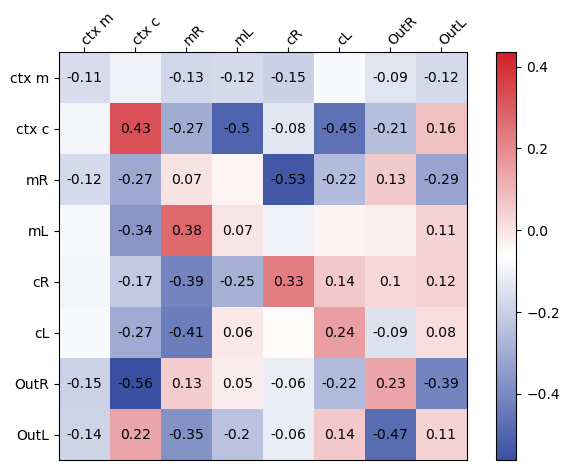

In [21]:
w_rec = net_params["W_rec"]
fig_w_rec = analyzer.plot_recurrent_matrix()
plt.show()

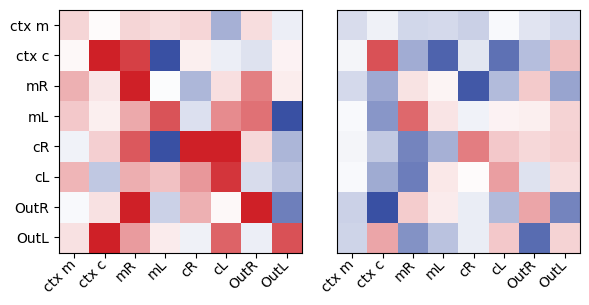

In [22]:
fig_w_rec_comparison = analyzer.plot_recurrent_matrix_comparison(w_rec_bar=w_rec_bar)
plt.show()

Plotting random trials


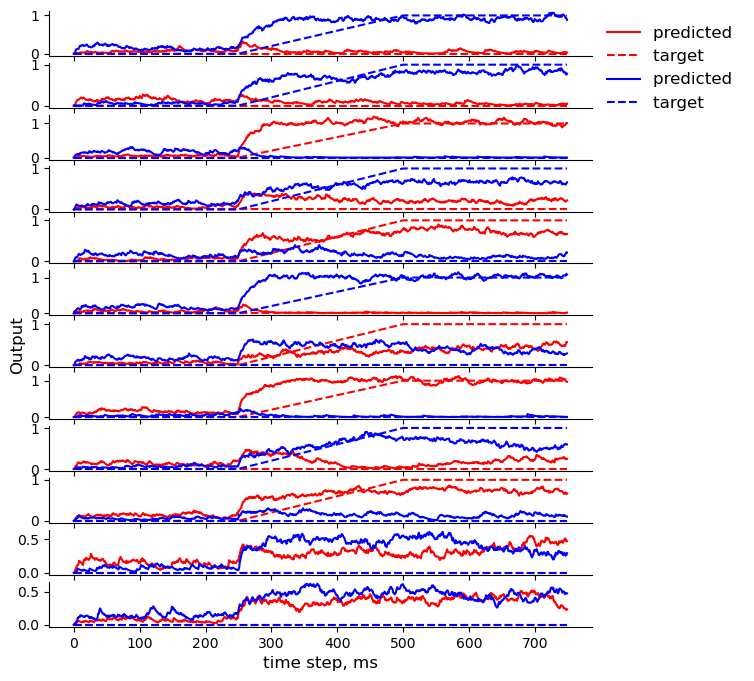

In [23]:
print(f"Plotting random trials")
inds = np.random.choice(np.arange(input_batch_valid.shape[-1]), 12)
inputs = input_batch_valid[..., inds]
targets = target_batch_valid[..., inds]
fig_trials = analyzer.plot_trials(inputs, targets, mask, sigma_rec=sigma_rec, sigma_inp=sigma_inp)
plt.show()

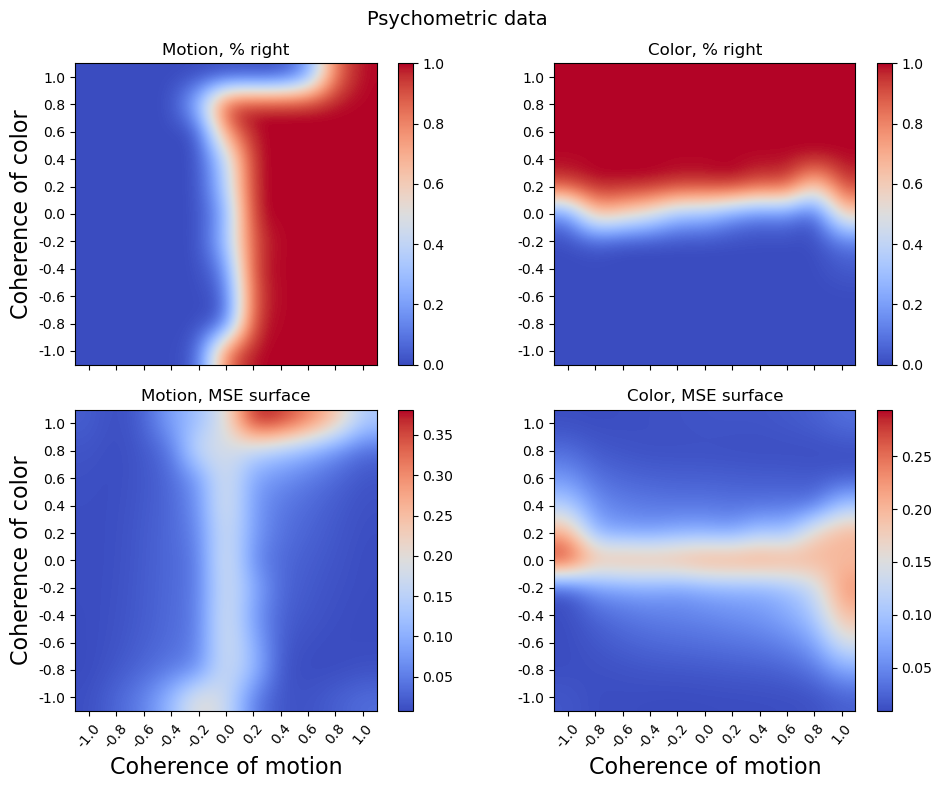

In [24]:
num_levels = len(task_data["coherences"])
analyzer.calc_psychometric_data(task, mask, num_levels=num_levels, num_repeats=31, sigma_rec=0.03, sigma_inp=0.03)
fig_psycho = analyzer.plot_psychometric_data()
plt.show()

Analyzing fixed points
Calculating Line Attractor analytics
Analyzing points on a line attractor in motion context...


  0%|          | 0/101 [00:00<?, ?it/s]

Analyzing points on a line attractor in color context...


  0%|          | 0/101 [00:00<?, ?it/s]

KeyError: 'motion'

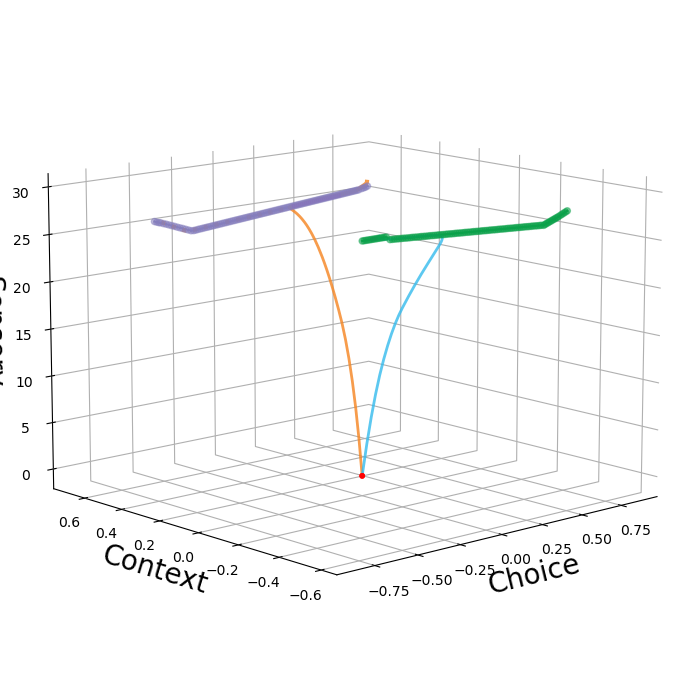

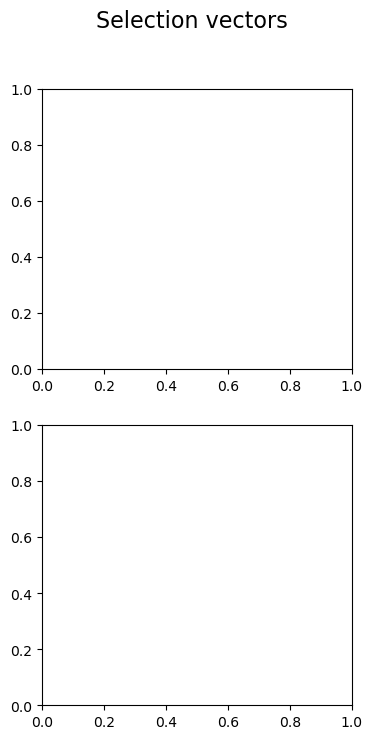

In [25]:
print(f"Analyzing fixed points")
dsa = DynamicSystemAnalyzerCDDM(circuit)
params = {"fun_tol": 0.05,
          "diff_cutoff": 1e-4,
          "sigma_init_guess": 15,
          "patience": 50,
          "stop_length": 50,
          "mode": "approx"}
dsa.get_fixed_points(Input=np.array([1, 0, 0.5, 0.5, 0.5, 0.5]), **params)
dsa.get_fixed_points(Input=np.array([0, 1, 0.5, 0.5, 0.5, 0.5]), **params)
print(f"Calculating Line Attractor analytics")
dsa.calc_LineAttractor_analytics(N_points=101)
fig_LA3D = dsa.plot_LineAttractor_3D()
if disp: plt.show()

LA_data_lc = dsa.fp_data
LA_data_RNN = pickle.load(open(os.path.join(RNN_folder_full_path, f"{mse_score_RNN}_LA_data.pkl"), "rb+"))
fig_selection_vects = analyzer.plot_selection_vectors(Q, LA_data_lc, LA_data_RNN)
plt.show()